In [1]:
from sktime.datasets import load_UCR_UEA_dataset
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datasets import load_arrow_head
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sktime.transformations.panel.catch22 import Catch22
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor, TSFreshRelevantFeatureExtractor
from sktime.datasets import load_from_ucr_tsv_to_dataframe
import os
from sktime.transformations.panel.rocket import Rocket
from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
def generate_random_walk(n_steps, std_dev):
    return np.random.normal(0, std_dev, n_steps).cumsum()

def generate_linear(n_steps, mag):
    return mag*np.ones(n_steps).cumsum()

In [3]:
def add_noise(df, level=0.1):
    l = []
    X_test_ = pd.DataFrame()
    for i in range(len(df)):
        series = df['dim_0'].iloc[i]
        l.append(pd.Series(series + np.random.normal(0, level, len(series))))
    X_test_["dim_0"] = l
    return X_test_

def add_constant(df, level=0.1):
    l = []
    X_test_ = pd.DataFrame()
    for i in range(len(df)):
        series = df['dim_0'].iloc[i]
        l.append(pd.Series(series + level))
    X_test_["dim_0"] = l
    return X_test_

def mul_constant(df, level=0.1):
    l = []
    X_test_ = pd.DataFrame()
    for i in range(len(df)):
        series = df['dim_0'].iloc[i]
        l.append(pd.Series(series*level))
    X_test_["dim_0"] = l
    return X_test_

def add_random_walk(df, level=0.1):
    l = []
    X_test_ = pd.DataFrame()
    for i in range(len(df)):
        series = df['dim_0'].iloc[i]
        l.append(pd.Series(series+generate_random_walk(len(series), level)))
    X_test_["dim_0"] = l
    return X_test_

def add_linear(df, level=0.1):
    l = []
    X_test_ = pd.DataFrame()
    for i in range(len(df)):
        series = df['dim_0'].iloc[i]
        l.append(pd.Series(series+generate_linear(len(series), level)))
    X_test_["dim_0"] = l
    return X_test_

# low, high pass filter


In [4]:
noise_levels = [0.0, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
const_levels = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0, 3.0, 5.0, 20.0, 100.0]
#noise_levels = [5, 2, 1, 0.8, 0.5, 0.3, 0.05, 0, -0.5, -1, -2, -5]

In [5]:
dataset = 'Car'
X_train, y_train = load_from_ucr_tsv_to_dataframe(
    os.path.join('UCRArchive_2018/', f"{dataset}/{dataset}_TRAIN.tsv")
)

X_test, y_test = load_from_ucr_tsv_to_dataframe(
    os.path.join('UCRArchive_2018/', f"{dataset}/{dataset}_TEST.tsv")
)

In [6]:
tfr = TSFreshFeatureExtractor(default_fc_parameters="efficient", show_warnings=False, n_jobs=-1)
tfr.fit(X_train, y_train)
Xtsfresh_train = tfr.transform(X_train)
Xtsfresh_test = tfr.transform(X_test)

Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 16.61it/s]


In [7]:
data = {'method': [], 'accuracy': [], 'run': [], 'noise': []}

In [8]:
for noise in noise_levels:
    print(noise)
    v = tfr.transform(add_noise(X_test.copy(), level=noise))
    for run in range(20):
        rf = RandomForestClassifier(n_jobs=-1)
        rf.fit(Xtsfresh_train, y_train)
        y_pred = rf.predict(v)
        data['accuracy'].append(accuracy_score(y_test, y_pred))
        data['method'].append('tsfresh')        
        data['run'].append(run)
        data['noise'].append(noise)
        

0.0


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 15.60it/s]


0.0001


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 15.04it/s]


0.001


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 15.73it/s]


0.01


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 15.35it/s]


0.05


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 15.93it/s]


0.1


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 16.10it/s]


0.2


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 15.62it/s]


0.3


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 14.64it/s]


In [9]:
trf = Rocket(num_kernels=256)
trf.fit(X_train, y_train)
Xrocket_train = trf.transform(X_train)
Xrocket_test = trf.transform(X_test)

In [10]:
for noise in noise_levels:
    print(noise)
    v = trf.transform(add_linear(X_test.copy(), level=noise))
    accs = []
    for run in range(20):
        rf = RandomForestClassifier(n_jobs=-1)
        rf.fit(Xrocket_train, y_train)
        y_pred = rf.predict(v)
        data['accuracy'].append(accuracy_score(y_test, y_pred))
        data['method'].append('rocket')        
        data['run'].append(run)
        data['noise'].append(noise)
        

0.0
0.0001
0.001
0.01
0.05
0.1
0.2
0.3


In [11]:
for noise in noise_levels:
    for run in range(200):
        y_pred = np.random.permutation(y_test)
        data['accuracy'].append(accuracy_score(y_test, y_pred))
        data['method'].append('baseline')        
        data['run'].append(run)
        data['noise'].append(noise)

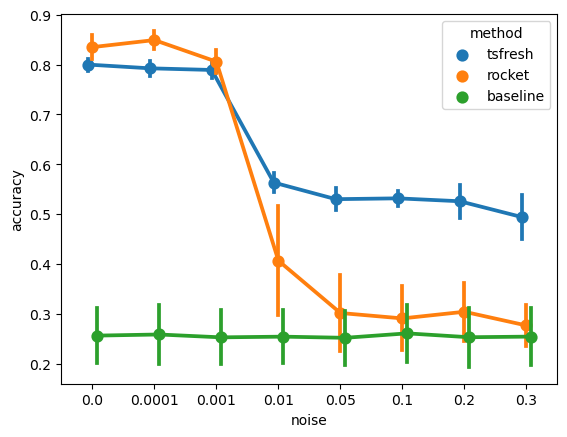

In [12]:
df = pd.DataFrame(data)
g = sns.pointplot(data=df, x="noise", y="accuracy", hue="method", dodge=0.15, errorbar='sd')


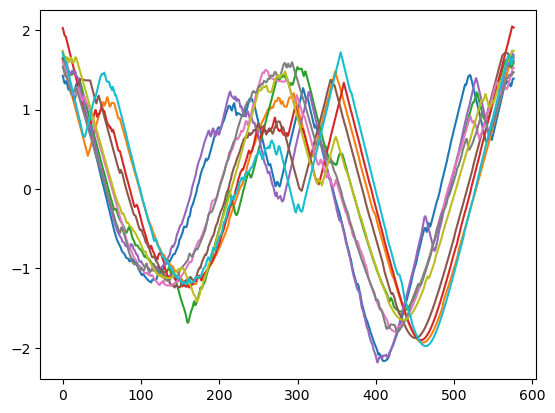

In [13]:
for i in range(10):
    plt.plot(X_test['dim_0'].iloc[i])

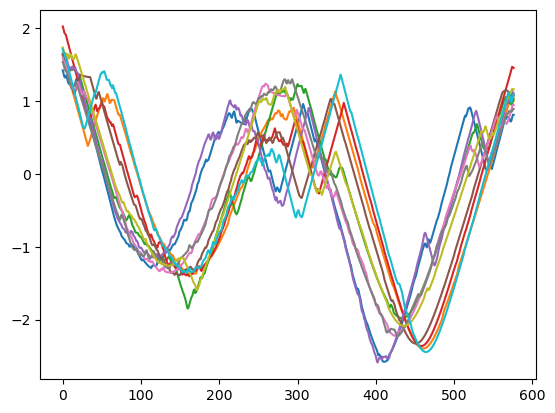

In [14]:
for i in range(10):
    plt.plot(add_linear(X_test.copy(), level=-0.001)['dim_0'].iloc[i])
    

In [15]:
dg=dfgdg

NameError: name 'dfgdg' is not defined

In [ ]:
fresh = [Xtsfresh_train]
rocket = [Xrocket_test]

for noise in [0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0, 3.0]:
    fresh.append(tfr.transform(add_noise(X_test.copy(), level=noise)))
    rocket.append(trf.transform(add_noise(X_test.copy(), level=noise)))    

In [ ]:
for representation in fresh:
    accs = []
    for _ in range(20):
        rf = RandomForestClassifier(n_jobs=-1)
        rf.fit(Xtsfresh_train, y_train)
        y_pred = rf.predict(representation)
        accs.append(accuracy_score(y_test, y_pred))
    print(np.mean(accs))

In [ ]:
#
#        TX_train, TX_test, Ty_train, Ty_test = train_test_split(representation, y_test, test_size=0.2)
#
#        rf = RandomForestClassifier(n_jobs=-1)
#        rf.fit(TX_train, Ty_train)
#        y_pred = rf.predict(TX_test)
#        accs.append(accuracy_score(Ty_test, y_pred))
#    print(np.mean(accs))

In [ ]:
sff = sgfsgf

In [ ]:
X_test['dim_0'].iloc[0]

In [ ]:
pd.Series([3,6,2,4,5])

In [ ]:
# import to retrieve examples
from sktime.datatypes import get_examples
get_examples(mtype="pd.DataFrame", as_scitype="Series")[0]

In [ ]:
pd.Series(np.array([2, 35, 35]))

In [ ]:
X_test_['dim_0']

In [ ]:
X_test_['dim_0'].iloc[0]

In [ ]:
sg=sgsgf

In [ ]:
#def add_noise(df, column='dim_0', noise_level=0.1):
#    """
#    This function takes a pandas DataFrame, a column name, and a noise level. 
#    It adds Gaussian noise to the series in each row of the specified column.
#    """
#
#    # Define a helper function to add noise to a series
#    def noise(series):
#        return series + np.random.normal(0, noise_level, len(series))
#
#    # Apply the helper function to each row in the DataFrame
#    df[column] = df[column].apply(noise)
#
#    return df
#
#X_test_ = add_noise(X_test.copy())

In [ ]:
#X_test_

fdthgd=sfgsg

In [ ]:
X_test['dim_0'].apply(lambda series: series + pd.Series(np.random.normal(0, 0.5, len(series))))

In [ ]:
sdfs=sdfsf

In [ ]:
type(X_test_['dim_0'].iloc[0])

In [ ]:
type(pd.Series(np.array(X_test['dim_0'].iloc[0])))